In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

### Neural Network with three hidden layers
The number of input layer neurons have to be same as the number of input features. In this case my dataset FanSpeedDS has five features, so there are five inputLayerNeurons.
For three hidden layers, a suitable number of nuerons have been selectet.
The number of output layer neurons have to be the same as the number of output classes. In this case. There are five output classes (1 to 5). So threre are five outputLayerNeurons.

Four weight matrices have been randomly initialized,
W_IH1 is from input layer neurons to hidden layer 1 neurons
W_H12 if from hidden layer 1 neurons to hidden layer 2 neurons
W_H23 is from hidden layer 2 neurons to hidden layer 3 neurons
W_H3O is from hidden layer 3 neurons to output layer neurons

feedForward function has been adjusted to get the output of every hidden layer and the output layer via sigmoid function. The output from the output layer neurons are the prediction.

For backPropagation function every weight is being updated by introducing hidden_delta for eache output layer and they travels backwards from the output layer weight matrix to the hidden layer 1 weight matrix.

In [71]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 5
        hiddenLayer1Neurons = 10
        hiddenLayer2Neurons = 20
        hiddenLayer3Neurons = 10
        outputLayerNeurons = 5

        self.W_IH1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_H12 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H23 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_H3O = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)
        self.learning_rate = 0.01

    def sigmoid(self, x, der=False):
        if der == True:
          return x * (1 - x)
        else:
          return 1 / (1 + np.exp(-x))

    # Forward propagation to the parediction
    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_IH1)
        self.hidden1_output = self.sigmoid(hidden1_input)  # Getting output from hidden layer 1 neurons

        hidden2_input = np.dot(self.hidden1_output, self.W_H12)
        self.hidden2_output = self.sigmoid(hidden2_input)  # Getting output from hidden layer 2 neurons

        hidden3_input = np.dot(self.hidden2_output, self.W_H23)
        self.hidden3_output = self.sigmoid(hidden3_input) # Getting output from hidden layer 3 neurons

        output_input = np.dot(self.hidden3_output, self.W_H3O)
        pred = self.sigmoid(output_input) # Getting output from output layers

        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred # Error from the final output
        output_delta = output_error * self.learning_rate * self.sigmoid(pred, True)

        hidden3_error = output_delta.dot(self.W_H3O.T)  # Error from the hidden layer3
        hidden3_delta = hidden3_error * self.learning_rate * self.sigmoid(self.hidden3_output, True)

        hidden2_error = hidden3_delta.dot(self.W_H23.T) # Error from the hidden layer2
        hidden2_delta = hidden2_error * self.learning_rate * self.sigmoid(self.hidden2_output, True)

        hidden1_error = hidden2_delta.dot(self.W_H12.T) # Error from the hidden layer1
        hidden1_delta = hidden1_error * self.learning_rate * self.sigmoid(self.hidden1_output, True)

        # Adjusting the weights
        self.W_H3O += self.hidden3_output.T.dot(output_delta)
        self.W_H23 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_H12 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_IH1 += X.T.dot(hidden1_delta)


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

In [72]:
try:
    df = pd.read_csv('FanSpeedDS.csv')
    X = df[['temp', 'cpu', 'memory', 'disk', 'network']].values
    Y_labels = df[['fanspeed']].values.astype(int) # Ensure labels are integers

    # Manual Min-Max Scaling for input features
    X_min = X.min(axis=0, keepdims=True)
    X_max = X.max(axis=0, keepdims=True)
    X_scaled = (X - X_min) / (X_max - X_min + 1e-8)

    # Adjust labels to be 0-indexed (0 to num_classes - 1)
    Y_labels_adjusted = Y_labels - 1
    num_classes = len(np.unique(Y_labels_adjusted))
    Y_onehot = np.eye(num_classes)[Y_labels_adjusted.flatten()]

except FileNotFoundError:
    print("Error: 'FanSpeedDS.csv' not found. Please upload the CSV file.")
    exit()

In [73]:
df.head()

,temp,cpu,memory,disk,network,fanspeed
0,82,66,76,42,79,5
1,83,95,61,66,52,5
2,76,24,95,77,25,4
3,77,68,31,38,43,4
4,77,23,85,44,88,4


In [74]:
def train_test_split(X, Y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    return X[train_indices], X[test_indices], Y[train_indices], Y[test_indices]

X_train, X_test, Y_train_onehot, Y_test_onehot = train_test_split(X_scaled, Y_onehot, test_size=0.2, random_state=42)
Y_train_labels = np.argmax(Y_train_onehot, axis=1)
Y_test_labels = np.argmax(Y_test_onehot, axis=1)

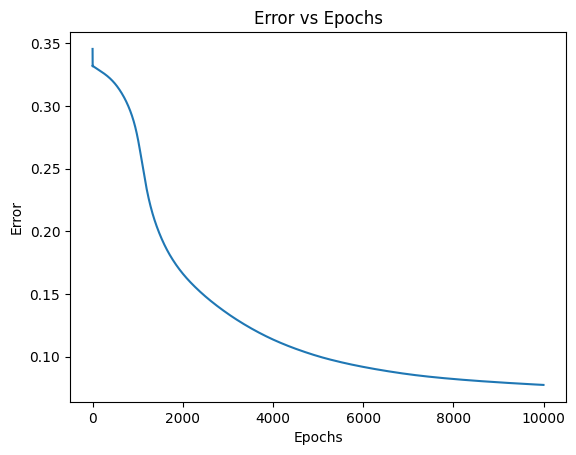

In [75]:
NN = NeuralNetwork()

err = []
for i in range(10000):
  NN.train(X_train, Y_train)
  err.append(np.mean(np.abs(Y_train - NN.feedForward(X_train))))
plt.plot(err)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Error vs Epochs")
plt.show()

# The neural network, is trained to classify fan speed into five classes, had a poor overall accuracy of approximately 0.1765 with extreme performance disparity across classes; while it achieved some success in classification of Class 1 and Class 3, but failed to classify Classes 2, 4, and 5. This finding indicates problems such as potential data imbalance, inefficient network architecture and choice of hyperparameters, the use of sigmoid activation in hidden layers, and the use of extensive evaluation metrics apart from overall accuracy.

In [76]:
def map_to_fanspeed(pred):
    predicted_class = np.argmax(pred, axis=1)
    fanspeed = predicted_class + 1
    return fanspeed

predictions = NN.feedForward(X_test)
Y_pred = map_to_fanspeed(predictions)

print(Y_pred)

[3 3 3 2 4 1 4 4 2 4 5 2 3 2 4 4 1 2 1 3 3 3 2 5 3 2 3 3 2 4 3 2 3 2 2 3 3
 3 2 3 3 2 3 3 2 4 2 5 2 1 3 2 3 3 2 3 3 3 2 1 3 2 3 2 2 3 3 2 3 2 3 3 3 4
 2 2 2 2 4 4 3 3 3 2 2 2 3 2 1 2 2 2 2 2 2 1 3 2 1 1]


In [77]:
def accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

Y_test_original = (Y_test * (Y_max - Y_min) + Y_min).astype(int)
Y_test_fanspeed = map_to_fanspeed(Y_test_original)

acc = accuracy(Y_test_fanspeed, Y_pred)
print(f"Accuracy: {acc}")


Accuracy: 9.0


In [79]:
predictions_test_probabilities = NN.feedForward(X_test)
predictions_test_labels = np.argmax(predictions_test_probabilities, axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred, class_label):
    tp = np.sum((y_true == class_label) & (y_pred == class_label))
    fp = np.sum((y_true != class_label) & (y_pred == class_label))
    return tp / (tp + fp + 1e-8)

def recall(y_true, y_pred, class_label):
    tp = np.sum((y_true == class_label) & (y_pred == class_label))
    fn = np.sum((y_true == class_label) & (y_pred != class_label))
    return tp / (tp + fn + 1e-8)

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-8)

overall_accuracy = accuracy(Y_test_labels, predictions_test_labels)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

for i in range(num_classes):
    prec = precision(Y_test_labels, predictions_test_labels, i)
    rec = recall(Y_test_labels, predictions_test_labels, i)
    f1 = f1_score(prec, rec)
    print(f"Class {i+1}:")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")
    print(f"  F1-Score: {f1:.4f}")

Overall Accuracy: 0.1600
Class 1:
  Precision: 0.1111
  Recall: 0.0625
  F1-Score: 0.0800
Class 2:
  Precision: 0.1282
  Recall: 0.2500
  F1-Score: 0.1695
Class 3:
  Precision: 0.2368
  Recall: 0.5294
  F1-Score: 0.3273
Class 4:
  Precision: 0.0909
  Recall: 0.0455
  F1-Score: 0.0606
Class 5:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


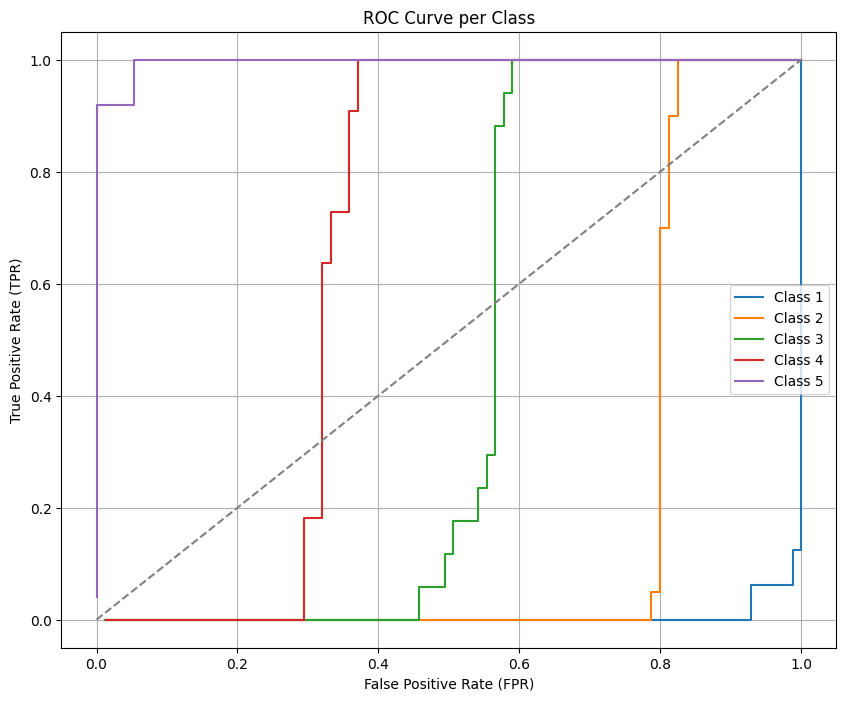

In [90]:
def roc_curve_per_class(y_true, y_scores, num_classes):

    fpr_all = []
    tpr_all = []
    for class_idx in range(num_classes):
      fpr = []
      tpr = []
      thresholds = sorted(np.unique(y_scores[:, class_idx]), reverse=True)
      for threshold in thresholds:
          y_pred = (y_scores[:, class_idx] >= threshold).astype(int)
          tp = np.sum((y_true[:,class_idx] == 1) & (y_pred == 1))
          fp = np.sum((y_true[:,class_idx] == 0) & (y_pred == 1))
          tn = np.sum((y_true[:,class_idx] == 0) & (y_pred == 0))
          fn = np.sum((y_true[:,class_idx] == 1) & (y_pred == 0))

          if (tp + fn) == 0:
            tpr_val = 0
          else:
            tpr_val = tp / (tp + fn)  # Sensitivity or True Positive Rate

          if (fp + tn) == 0:
            fpr_val = 0
          else:
            fpr_val = fp / (fp + tn)  # False Positive Rate
          fpr.append(fpr_val)
          tpr.append(tpr_val)
      fpr_all.append(fpr)
      tpr_all.append(tpr)

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr_all[i], tpr_all[i], label=f'Class {i+1}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve per Class')
    plt.legend()
    plt.grid(True)
    plt.show()
roc_curve_per_class(Y_test_onehot, predictions_test_probabilities, num_classes)
